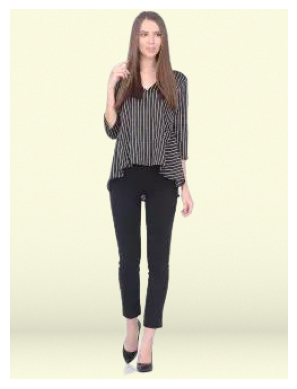

In [95]:
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
import numpy as np
import os
import random
import time

#затемнение линии градиента
def darken_color(color, factor=0.9):
    return tuple(int(c * factor) for c in color)

#создание фона
def create_surface_background_with_gradient_line(width, height, base_color=(255, 255, 255), gradient_intensity=0.6, noise_intensity=0.05, line_position=0.75):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    y_coords = torch.linspace(0, 1, height, device=device).view(-1, 1).expand(-1, width)
    line_y = line_position
    line_color = darken_color(base_color)
    base_color_tensor = torch.tensor(base_color, dtype=torch.float32, device=device) / 255.0
    line_color_tensor = torch.tensor(line_color, dtype=torch.float32, device=device) / 255.0
    gradient_above = torch.abs(y_coords - line_y) / line_y
    gradient_below = torch.abs(y_coords - line_y) / (1 - line_y)
    gradient_combined = torch.where(y_coords < line_y, gradient_above, gradient_below)
    sharpness_factor = 8.0
    gradient_line = torch.exp(-sharpness_factor * torch.abs(y_coords - line_y))
    gradient_factor = (1 - gradient_intensity) + gradient_intensity * (1 - gradient_combined) * gradient_line
    gradient_image = gradient_factor.unsqueeze(-1) * line_color_tensor + (1 - gradient_factor).unsqueeze(-1) * base_color_tensor
    noise = noise_intensity * torch.randn(height, width, 3, device=device)
    noisy_image = gradient_image + noise
    noisy_image = torch.clamp(noisy_image, 0, 1)
    noisy_image_cpu = noisy_image.cpu().numpy()
    noisy_image_np = (noisy_image_cpu * 255).astype(np.uint8)
    background_image = Image.fromarray(noisy_image_np)
    return background_image

# Было найдено несколько подходящих цветов для фона, используются только светлые тона
colors = {
    "1": (240, 240, 240),  # серый
    "2": (255, 248, 225),  # кремовый
    "3": (245, 245, 220),  # Бежевый
    "4": (224, 247, 251),  # голубой
    "5": (232, 245, 224),  # зеленый
    "6": (252, 228, 236),  # розовый
    "7": (255, 249, 196),  # желтый
    "8": (237, 231, 246),  # фиолетовый
    "9": (255, 224, 178),  # ораньжевый
    "10": (224, 242, 241), # зеленый
}

base_color = colors['3'] #выбор цвета фона

# Директория с изображениями
image_dir = '/kaggle/input/remove-background/sirius_data-6fb0f21e-6f0f-4d7d-9a83-dab650e7ea10/sirius_data/'
image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]

# Загрузка модели
from transformers import AutoModelForImageSegmentation
birefnet = AutoModelForImageSegmentation.from_pretrained('ZhengPeng7/BiRefNet', trust_remote_code=True)

torch.set_float32_matmul_precision(['high', 'highest'][0])
birefnet.to('cuda')
birefnet.eval()

#проводим сегментацию
def extract_object(birefnet, imagepath):
    image_size = (1024, 1024)
    transform_image = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    image = Image.open(imagepath).convert("RGB")
    input_images = transform_image(image).unsqueeze(0).to('cuda')

    # Прогнозирование
    with torch.no_grad():
        preds = birefnet(input_images)[-1].sigmoid().cpu()
    pred = preds[0].squeeze()
    pred_pil = transforms.ToPILImage()(pred)
    mask = pred_pil.resize(image.size)
    image.putalpha(mask)
    return image, mask

#для создания эффекта объема, я нахожу самое нижнее положение маски и делаю линию градиента немного выще

#самое нижнее положение маски
def get_mask_position(mask):
    mask_array = np.array(mask)
    non_zero_indices = np.where(mask_array > 0)
    
    if non_zero_indices[0].size > 0:
        return non_zero_indices[0].max() / mask_array.shape[0]
    return 0.0

#замена фона
def replace_background(foreground_image, mask, background):
    background = background.resize(foreground_image.size)

    if foreground_image.mode != 'RGBA':
        foreground_image = foreground_image.convert('RGBA')

    composed_image = Image.composite(foreground_image, background, mask)
    return composed_image


image_file = '1.jpg'
image_path = os.path.join(image_dir, random_image_file)
foreground, mask = extract_object(birefnet, image_path)

mask_position = get_mask_position(mask) - 0.125

# Создание фона с горизонтальной градиентной линией
background_image = create_surface_background_with_gradient_line(
    foreground.size[0], 
    foreground.size[1], 
    base_color, 
    gradient_intensity=1.2, 
    noise_intensity=0.005, 
    line_position=mask_position
)

# Замена фона
result_image = replace_background(foreground, mask, background_image)

# Визуализация
plt.axis("off")
plt.imshow(result_image)
plt.show()

Обработка предоставленного датасета в 500 изображений заняла около 8 минут

In [ ]:
pip install einops decord

In [45]:
import numpy as np
import torch
import torchvision.transforms as T
from decord import VideoReader, cpu
from PIL import Image
from torchvision.transforms.functional import InterpolationMode
from transformers import AutoModel, AutoTokenizer

IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)


#обработка входного изображения

def build_transform(input_size):
    MEAN, STD = IMAGENET_MEAN, IMAGENET_STD
    transform = T.Compose([
        T.Lambda(lambda img: img.convert('RGB') if img.mode != 'RGB' else img),
        T.Resize((input_size, input_size), interpolation=InterpolationMode.BICUBIC),
        T.ToTensor(),
        T.Normalize(mean=MEAN, std=STD)
    ])
    return transform

def find_closest_aspect_ratio(aspect_ratio, target_ratios, width, height, image_size):
    best_ratio_diff = float('inf')
    best_ratio = (1, 1)
    area = width * height
    for ratio in target_ratios:
        target_aspect_ratio = ratio[0] / ratio[1]
        ratio_diff = abs(aspect_ratio - target_aspect_ratio)
        if ratio_diff < best_ratio_diff:
            best_ratio_diff = ratio_diff
            best_ratio = ratio
        elif ratio_diff == best_ratio_diff:
            if area > 0.5 * image_size * image_size * ratio[0] * ratio[1]:
                best_ratio = ratio
    return best_ratio

def dynamic_preprocess(image, min_num=1, max_num=12, image_size=448, use_thumbnail=False):
    orig_width, orig_height = image.size
    aspect_ratio = orig_width / orig_height

    target_ratios = set(
        (i, j) for n in range(min_num, max_num + 1) for i in range(1, n + 1) for j in range(1, n + 1) if
        i * j <= max_num and i * j >= min_num)
    target_ratios = sorted(target_ratios, key=lambda x: x[0] * x[1])
    target_aspect_ratio = find_closest_aspect_ratio(
        aspect_ratio, target_ratios, orig_width, orig_height, image_size)

    target_width = image_size * target_aspect_ratio[0]
    target_height = image_size * target_aspect_ratio[1]
    blocks = target_aspect_ratio[0] * target_aspect_ratio[1]

    resized_img = image.resize((target_width, target_height))
    processed_images = []
    for i in range(blocks):
        box = (
            (i % (target_width // image_size)) * image_size,
            (i // (target_width // image_size)) * image_size,
            ((i % (target_width // image_size)) + 1) * image_size,
            ((i // (target_width // image_size)) + 1) * image_size
        )
        split_img = resized_img.crop(box)
        processed_images.append(split_img)
    assert len(processed_images) == blocks
    if use_thumbnail and len(processed_images) != 1:
        thumbnail_img = image.resize((image_size, image_size))
        processed_images.append(thumbnail_img)
    return processed_images

def load_image(image_file, input_size=448, max_num=12):
    image = Image.open(image_file).convert('RGB')
    transform = build_transform(input_size=input_size)
    images = dynamic_preprocess(image, image_size=input_size, use_thumbnail=True, max_num=max_num)
    pixel_values = [transform(image) for image in images]
    pixel_values = torch.stack(pixel_values)
    return pixel_values

#используется VLM модель, при относительно небольшом размере, она выдает крайне неплохие результаты, так же можно использовать более крупные версии этой модели, они легко запускаются локально даже на видеокарте Tesla t4, в случае если памяти недостаточно, можно разделить модельно на несколько видеокарт
path = 'OpenGVLab/InternVL2-2B'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AutoModel.from_pretrained(
    path,
    torch_dtype=torch.bfloat16,
    low_cpu_mem_usage=True,
    use_flash_attn=True,
    trust_remote_code=True).eval()
model.to(device)
tokenizer = AutoTokenizer.from_pretrained(path, trust_remote_code=True, use_fast=False)

pixel_values = load_image('/kaggle/input/remove-background/sirius_data-6fb0f21e-6f0f-4d7d-9a83-dab650e7ea10/sirius_data/1.jpg', max_num=12).to(torch.bfloat16).to(device)
generation_config = dict(max_new_tokens=96, do_sample=True)

#время генерации на видеокарте Tesla t4 занимает примерно 10 секунд

question = f"<image>\n make a short description of the image"
response = model.chat(tokenizer, pixel_values, question, generation_config)
print(f'User: {question}\nAssistant: {response}')


User: <image>
 make a short description of the image
Assistant: The image features a woman dressed in a stylish black and white vertically striped blouse paired with black trousers. She is wearing black heels. Her long hair is styled straight and she appears to be in a relaxed yet poised posture with her left hand touching her hair.


**Получение токена GigaChat**

In [ ]:
import requests

url = "https://ngw.devices.sberbank.ru:9443/api/v2/oauth"

payload='scope=GIGACHAT_API_PERS'
headers = {
  'Content-Type': 'application/x-www-form-urlencoded',
  'Accept': 'application/json',
  'RqUID': 'ваш RqUID',
  'Authorization': 'Basic ваш ключ'
}

token_response = requests.request("POST", url, headers=headers, data=payload,verify=False)

print(token_response.text)

In [60]:
#разные виды промтов
prompts = {
    'официальное': '''представь, что ты продавец, придумай название товара и составь краткое описание своего товара на основе этого описания, подчеркнув основные характеристики, функции и преимущества в официальном стиле.''',
    'привлекательное': '''представь, что ты продавец, придумай название товара и составь краткое описание своего товара на основе этого описания,  уделяя особое внимание функционалу, дизайну, цвету и ключевым особенностям, чтобы привлечь потенциальных покупателей.''',
    'подробное': '''представь, что ты продавец, придумай название товара и составь краткое, но подробное описание своего товара на основе этого описания, материала покрытия, цвета, размера, функций и преимуществ для целевой аудитории.''',
}

In [68]:
import requests
import json
#запрос к GigaChat
def req_toGigaChat(prompt_type,img_description):
    url = "https://gigachat.devices.sberbank.ru/api/v1/chat/completions"

    payload = json.dumps({
      "model": "GigaChat",
      "messages": [
        {
        "role": "user",
        "content": f"{prompts[prompt_type]}, забудь про все объекты на изображении, кроме твоего товара,твой товар это конкретная вещь, ты должен составить описание только по самому товару, игнорируй другие объекты, вот описание: {img_description}, верни ответ в формате json, в нем должно быть 'name' - название товара, 'description'- описание товара"
        },
      ],
      "n": 1,
      "stream": False,
      "max_tokens": 256,
      "update_interval": 0
    })
    headers = {
      'Content-Type': 'application/json',
      'Accept': 'application/json',
      'Authorization': 'Bearer "ваш токен"'
    }

    giga_response = requests.request("POST", url, headers=headers, data=payload,verify=False)

    return giga_response.text

In [91]:
prompt_type = 'подробное' # привлекательное или официальное

In [ ]:
text = req_toGigaChat(prompt_type,response)
text_json = json.loads(text)['choices'][0]['message']['content']
text_json = json.loads(text_json)

пример работы

тип описания: подробное

название товара: Стильная блузка с вертикальными полосками

описание товара: Эта стильная блузка с вертикальными полосками выполнена в черном и белом цветах. Она идеально сочетается с черными брюками и добавляет элегантности образу. Блузка имеет классический крой и удобна в носке. Материал изделия - хлопок, что делает его приятным на ощупь и обеспечивает комфорт в течение всего дня. Размер блузки можно подобрать индивидуально, так как она доступна в нескольких размерах. Благодаря своему универсальному дизайну, эта блузка станет отличным дополнением к любому гардеробу.


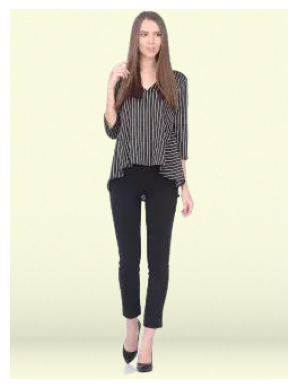

In [93]:
print(f"тип описания: {prompt_type}\n\nназвание товара: {text_json['name']}\n\n\
описание товара: {text_json['description']}")
plt.axis("off")
plt.imshow(result_image)
plt.show()

В этом блоке вы сможете оценить качество сегментации

In [17]:
from PIL import Image
import matplotlib.pyplot as plt
import os
import time
from IPython.display import clear_output

indx = os.listdir ('orig')
for id in indx:
    
    orig = Image.open(f'orig\\{id}')
    result = Image.open(f'result\\result_image_{id}')

    f, axarr = plt.subplots(1,2)

    axarr[0].imshow(orig)
    axarr[1].imshow(result)

    plt.axis("off")
    plt.show()
    time.sleep(2)
    clear_output(wait=False)


UnidentifiedImageError: cannot identify image file 'C:\\Users\\qacen\\OneDrive\\Документы\\GitHub\\sirius_t_bank\\orig\\55'